## 1. Setup and Data Loading

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
import xgboost as xgb

In [2]:
# Load data
train_df = pd.read_csv('../datasets/train_data.csv')
val_df = pd.read_csv('../datasets/val_data.csv')
feature_cols = ['Packet speed', 'Data speed', 'Packet Rate', 'Data Rate', 'Packet Size to Speed Ratio', 'Data to Packet Ratio',
                'Duration', 'Hour sin', 'Hour cos', 'Day of Week','Unique ports', 'Std packet speed', 'Max packet speed', 
                'Std data speed', 'Max data speed', 'Std packet length', 'Max packet length',
                'Std source IP count', 'Max source IP count', 'Mean time diff', 'Std time diff','pca_1','pca_2']

In [3]:
# Display a sample of the data
train_df.head()

,Unnamed: 0,Attack ID,Victim IP,Port number,Detect count,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,...,Std data speed,Max data speed,Std packet length,Max packet length,Std source IP count,Max source IP count,Mean time diff,Std time diff,pca_1,pca_2
0,0,1,IP_0001,4500,1,0.012829,0.035732,1383,6,2022-08-08 18:09:36,...,0.0,73,0.0,1383,0.0,6,0.0,0.0,5882.390147,-43.601836
1,1,2,IP_0002,4500,1,0.015076,0.044053,1506,1,2022-08-08 18:37:28,...,0.0,90,0.0,1506,0.0,1,0.0,0.0,77282.435588,23.576695
2,2,3,IP_0003,1200,2,0.014848,0.040137,1399,1,2022-08-08 18:41:25,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,12982.392646,-36.872210
3,3,4,IP_0002,4500,1,0.013938,0.041605,1486,1,2022-08-08 18:47:49,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,9782.400003,-39.903941
4,4,5,IP_0004,12347,2,0.019272,0.055311,1518,1,2022-08-08 18:57:15,...,0.0,85,0.0,1486,0.0,1,0.0,0.0,-48320.362374,-39.977475


## 2. Data Preparation

In [4]:
# Prepare training and testing datasets
X_train = train_df[feature_cols] 
y_train = train_df['Type']       

X_test = val_df[feature_cols]      
y_test = val_df['Type']            

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### 2.1 Feature Scaling

In [5]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.2 SMOTE for Class Imbalance

In [10]:
# Check class distribution before SMOTE
print("Original class distribution:")
print(y_train.value_counts())

# Apply SMOTE
smote = SMOTE(sampling_strategy={'Normal traffic': 249013, 
                                 'Suspicious traffic': 50000, 
                                 'DDoS attack': 5000}, random_state=42)

class_mapping =  {}
for i, class_name in enumerate(le.classes_):
        class_mapping[class_name] = i
print(class_mapping)
smote_encoded = SMOTE(sampling_strategy={class_mapping['Normal traffic']: 249013,
                                        class_mapping['Suspicious traffic']: 50000,
                                        class_mapping['DDoS attack']: 5000},random_state=42)

# For regular data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# For scaled data
X_train_smote_scaled, y_train_smote_encoded = smote_encoded.fit_resample(X_train_scaled, y_train_encoded)

# Check class distribution after SMOTE
print("\nResampled class distribution:")
print(y_train_smote.value_counts())

Original class distribution:
Type
Normal traffic        249013
Suspicious traffic     13380
DDoS attack             2373
Name: count, dtype: int64
{'DDoS attack': 0, 'Normal traffic': 1, 'Suspicious traffic': 2}

Resampled class distribution:
Type
Normal traffic        249013
Suspicious traffic     50000
DDoS attack             5000
Name: count, dtype: int64


## 3. Modeling

We'll evaluate each model with:
1. Original data
2. Scaled data
3. SMOTE-resampled data
4. Scaled + SMOTE data

In [11]:
# Dictionary to store results for final comparison
results = {}

# Function to evaluate model and store results
def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, data_type):
    # Train model
    model.fit(X_train_data, y_train_data)
    
    # Predict and evaluate
    y_pred = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred, average="macro")
    conf_matrix = confusion_matrix(y_test_data, y_pred)
    
    # Print results
    print(f"{model_name} with {data_type} - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}")
    print(conf_matrix)
    
    # Store results for summary
    results[f"{model_name} ({data_type})"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2)
    }
    
    return model, y_pred, conf_matrix

### 3.1 Random Forest

In [12]:
# 1. Random Forest with original data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original, y_pred_rf, conf_rf = evaluate_model(
    rf_model, X_train, y_train, X_test, y_test, 
    "Random Forest", "original data"
)

Random Forest with original data - Accuracy: 0.4376, Recall: 0.4524
[[  495   541    19]
 [70866 55019     8]
 [ 1163   513  1376]]


In [13]:
# 2. Random Forest with scaled data
rf_scaled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scaled_model, y_pred_rf_scaled, conf_rf_scaled = evaluate_model(
    rf_scaled, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
    "Random Forest", "scaled data"
)

Random Forest with scaled data - Accuracy: 0.4356, Recall: 0.4311
[[  494   539    22]
 [70935 54954     4]
 [ 1371   495  1186]]


In [14]:
# 3. Random Forest with SMOTE data
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_model, y_pred_rf_smote, conf_rf_smote = evaluate_model(
    rf_smote, X_train_smote, y_train_smote, X_test, y_test, 
    "Random Forest", "SMOTE data"
)

Random Forest with SMOTE data - Accuracy: 0.4375, Recall: 0.5403
[[  522   509    24]
 [71266 54232   395]
 [  589   341  2122]]


In [15]:
# 4. Random Forest with SMOTE + scaled data
rf_smote_scaled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_scaled_model, y_pred_rf_smote_scaled, conf_rf_smote_scaled = evaluate_model(
    rf_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "Random Forest", "SMOTE + scaled data"
)

Random Forest with SMOTE + scaled data - Accuracy: 0.4303, Recall: 0.4372
[[  522   508    25]
 [71398 54244   251]
 [ 1523   351  1178]]


### 3.2 SVM

In [18]:
# 1. SVM with original data
svm_model = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_original, y_pred_svm, conf_svm = evaluate_model(
    svm_model, X_train, y_train_encoded, X_test, y_test_encoded, 
    "LinearSVC", "original data"
)

LinearSVC with original data - Accuracy: 0.9696, Recall: 0.3726
[[     2   1026     27]
 [     1 125682    210]
 [     2   2691    359]]


In [19]:
# 2. SVM with scaled data
svm_scaled = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_scaled_model, y_pred_svm_scaled, conf_svm_scaled = evaluate_model(
    svm_scaled, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
    "LinearSVC", "scaled data"
)

LinearSVC with scaled data - Accuracy: 0.9644, Recall: 0.5228
[[    17    945     93]
 [     1 123612   2280]
 [     2   1309   1741]]


In [20]:
# 3. SVM with SMOTE data
svm_smote = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_smote_model, y_pred_svm_smote, conf_svm_smote = evaluate_model(
    svm_smote, X_train_smote, y_train_smote_encoded, X_test, y_test_encoded, 
    "LinearSVC", "SMOTE data"
)

LinearSVC with SMOTE data - Accuracy: 0.9636, Recall: 0.5331
[[     6    995     54]
 [    10 123395   2488]
 [     7   1173   1872]]


In [21]:
# 4. SVM with SMOTE + scaled data
svm_smote_scaled = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_smote_scaled_model, y_pred_svm_smote_scaled, conf_svm_smote_scaled = evaluate_model(
    svm_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "LinearSVC", "SMOTE + scaled data"
)

LinearSVC with SMOTE + scaled data - Accuracy: 0.9485, Recall: 0.6110
[[    27    873    155]
 [     5 120688   5200]
 [     5    457   2590]]


### 3.3 XGBoost

In [22]:
# 1. XGBoost with original data
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_original, y_pred_xgb, conf_xgb = evaluate_model(
    xgb_model, X_train, y_train_encoded, X_test, y_test_encoded, 
    "XGBoost", "original data"
)

XGBoost with original data - Accuracy: 0.4924, Recall: 0.4384
[[  519   513    23]
 [62550 62502   841]
 [ 1506   549   997]]


In [23]:
# 2. XGBoost with scaled data
xgb_scaled = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_scaled_model, y_pred_xgb_scaled, conf_xgb_scaled = evaluate_model(
    xgb_scaled, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
    "XGBoost", "scaled data"
)

XGBoost with scaled data - Accuracy: 0.4628, Recall: 0.4222
[[  523   510    22]
 [66369 58714   810]
 [ 1577   546   929]]


In [24]:
# 3. XGBoost with SMOTE data
xgb_smote = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_smote_model, y_pred_xgb_smote, conf_xgb_smote = evaluate_model(
    xgb_smote, X_train_smote, y_train_smote_encoded, X_test, y_test_encoded, 
    "XGBoost", "SMOTE data"
)

XGBoost with SMOTE data - Accuracy: 0.5249, Recall: 0.4663
[[  506   525    24]
 [58926 66532   435]
 [ 1268   591  1193]]


In [25]:
# 4. XGBoost with SMOTE + scaled data
xgb_smote_scaled = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_smote_scaled_model, y_pred_xgb_smote_scaled, conf_xgb_smote_scaled = evaluate_model(
    xgb_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "XGBoost", "SMOTE + scaled data"
)

XGBoost with SMOTE + scaled data - Accuracy: 0.6860, Recall: 0.5568
[[  515   502    38]
 [38485 87165   243]
 [ 1171   386  1495]]


### 3.4 Feature importances and rf with only using top features

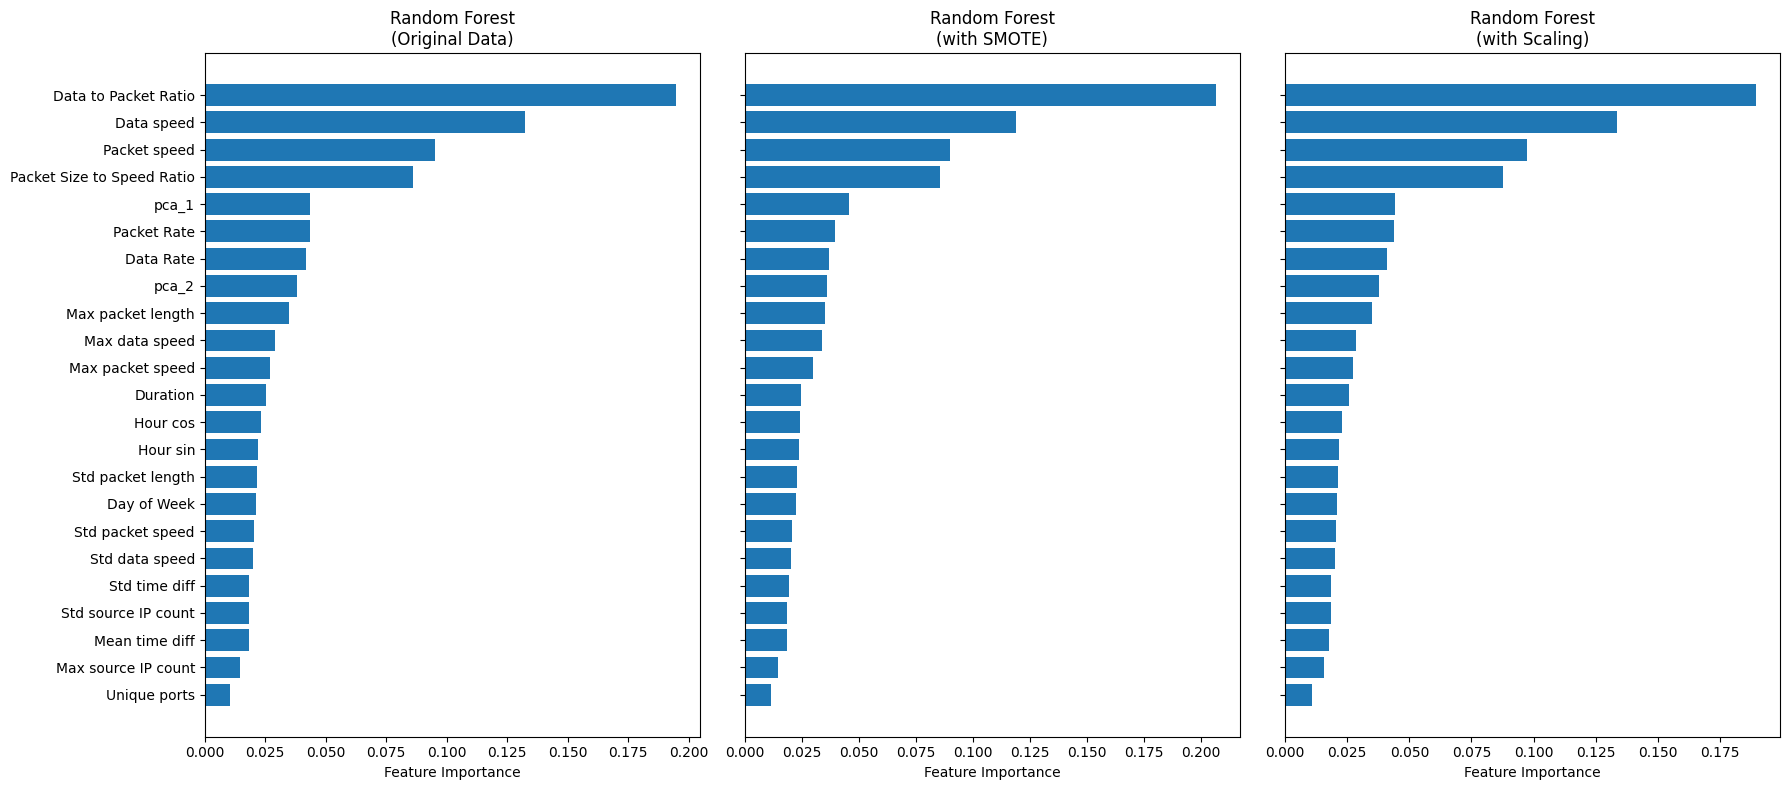

In [26]:
# Random Forest Feature Importance
feature_importances_rf = rf_original.feature_importances_
feature_importances_rf_smote = rf_smote_model.feature_importances_
feature_importances_rf_scale = rf_scaled_model.feature_importances_

# Visualize feature importance for the three RF models
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

# Sort the features by importance for better visualization
def plot_feature_importance(ax, importances, title):
    # Create array of feature importance with feature names as index
    indices = np.argsort(importances)
    
    # Plot the feature importance in descending order
    ax.barh(range(len(importances)), importances[indices], align='center')
    ax.set_yticks(range(len(importances)))
    ax.set_yticklabels([feature_cols[i] for i in indices])
    ax.set_title(title)
    ax.set_xlabel('Feature Importance')

# Plot for the standard Random Forest model
plot_feature_importance(axes[0], feature_importances_rf, 'Random Forest\n(Original Data)')

# Plot for Random Forest with SMOTE
plot_feature_importance(axes[1], feature_importances_rf_smote, 'Random Forest\n(with SMOTE)')

# Plot for Scaled Random Forest
plot_feature_importance(axes[2], feature_importances_rf_scale, 'Random Forest\n(with Scaling)')

plt.tight_layout()
plt.show()

In [27]:
# Train with only the top features
top_features = ['Data to Packet Ratio', 'Data speed', 'Packet speed', 
                'Packet Size to Speed Ratio', 'pca_1', 'Packet Rate', 'pca_2']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Scale these features
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

# Train model with just these features
rf_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top, y_pred_top, conf_top = evaluate_model(
    rf_top_features, X_train_top_scaled, y_train_encoded, X_test_top_scaled, y_test_encoded, 
    "Random Forest", "top features + scaled data"
)

Random Forest with top features + scaled data - Accuracy: 0.3227, Recall: 0.3701
[[  597   440    18]
 [85211 40680     2]
 [ 2163   214   675]]


### 3.5 Binary Classification

In [28]:
# Binary class version (Normal vs Any-Attack)
y_train_binary = (y_train_encoded != 0).astype(int)  # 0=Normal, 1=Any attack
y_test_binary = (y_test_encoded != 0).astype(int)

# Train binary classifier on scaled data
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_binary_model, y_pred_binary, conf_binary = evaluate_model(
    rf_binary, X_train_scaled, y_train_binary, X_test_scaled, y_test_binary, 
    "Random Forest Binary", "scaled data (Normal vs Attack)"
)

Random Forest Binary with scaled data (Normal vs Attack) - Accuracy: 0.3344, Recall: 0.4295
[[  555   500]
 [86025 42920]]


## 4. Results Comparison

In [29]:
# Create DataFrame from results dictionary for easy comparison
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by=['Recall', 'Accuracy'], ascending=False)

# Display the results
print("Models Performance Summary (Sorted by Recall)")
results_df

Models Performance Summary (Sorted by Recall)


,Accuracy,Recall
LinearSVC (SMOTE + scaled data),94.85,61.10
XGBoost (SMOTE + scaled data),68.60,55.68
Random Forest (SMOTE data),43.75,54.03
LinearSVC (SMOTE data),96.36,53.31
LinearSVC (scaled data),96.44,52.28
XGBoost (SMOTE data),52.49,46.63
Random Forest (original data),43.76,45.24
XGBoost (original data),49.24,43.84
Random Forest (SMOTE + scaled data),43.03,43.72
Random Forest (scaled data),43.56,43.11


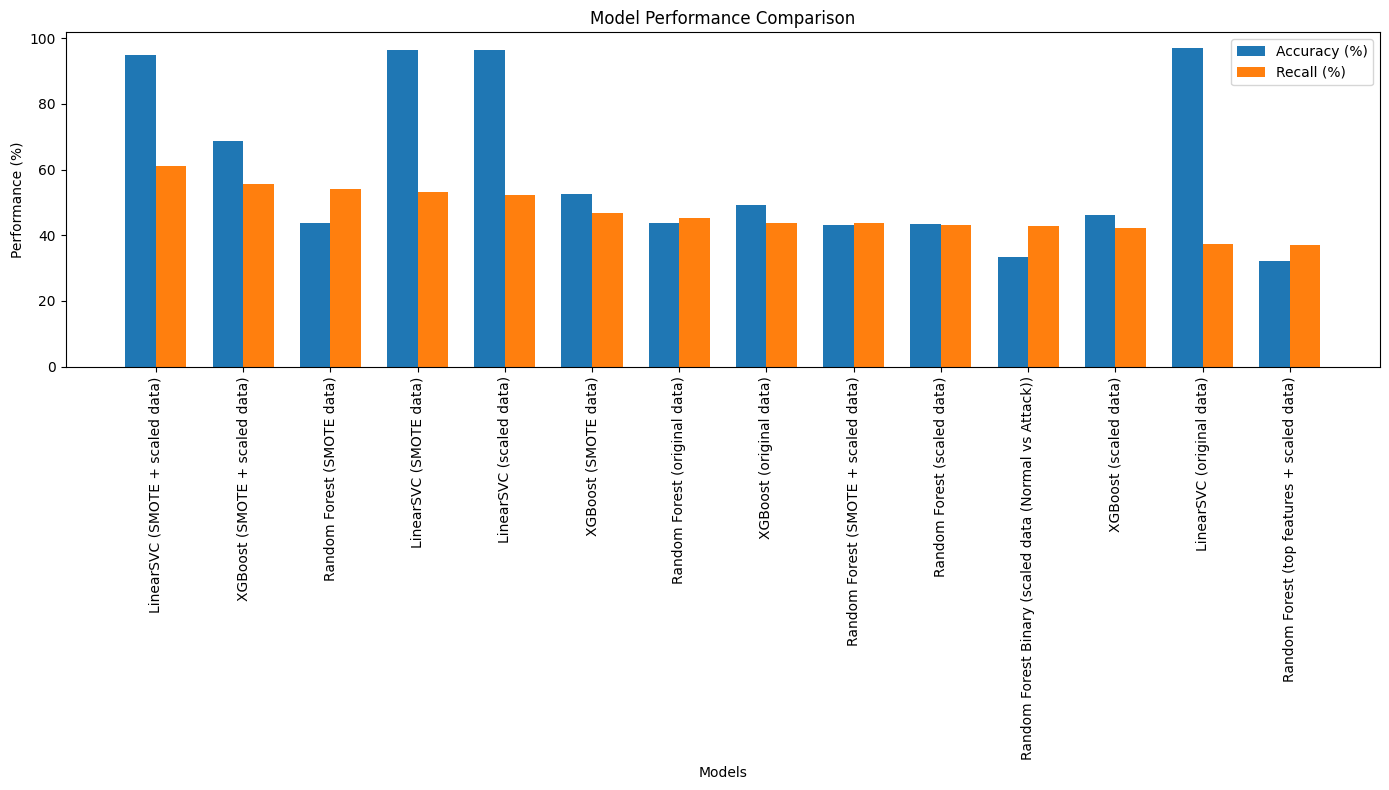

In [30]:
# Visualize the results
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(results))

accuracy_bars = plt.bar(index, results_df['Accuracy'], bar_width, label='Accuracy (%)')
recall_bars = plt.bar(index + bar_width, results_df['Recall'], bar_width, label='Recall (%)')

plt.xlabel('Models')
plt.ylabel('Performance (%)')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width / 2, results_df.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()